# Import Required Libraries
Import the necessary libraries, including PyTorch.

In [1]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from fastcore.all import *

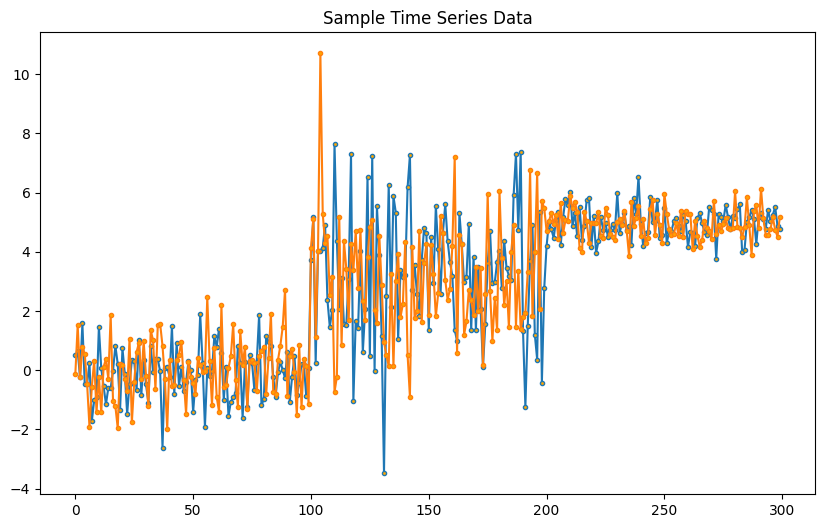

In [2]:
# Generate some sample data
np.random.seed(42)
X = np.concatenate([np.random.normal(size=(100, 2)),
                    np.random.normal(loc=3.0, scale=2.0, size=(100, 2)),
                    np.random.normal(loc=5.0, scale=0.5, size=(100, 2))])
# Plot X as a time series
plt.figure(figsize=(10, 6))
plt.plot(X[:, 0], ".-", label="observations", ms=6, mfc="orange")
plt.plot(X[:, 1], ".-", label="observations", ms=6, mfc="orange")
plt.title("Sample Time Series Data")
plt.show()



In [3]:
class GaussianHMM(nn.Module):
    def __init__(self, n_states, n_features):
        super(GaussianHMM, self).__init__()
        self.n_states = n_states
        self.n_features = n_features
        
        # Parameters: Initial probabilities, Transition matrix, Mean and Covariance for Gaussian emissions
        self.init_probs = nn.Parameter(torch.randn(n_states))
        self.trans_mat = nn.Parameter(torch.randn(n_states, n_states))
        self.means = nn.Parameter(torch.randn(n_states, n_features))
        self.covs = nn.Parameter(torch.stack([torch.eye(n_features) for _ in range(n_states)]))
        
    def forward(self, X):
        # Forward algorithm to compute log likelihood of X
        T = X.size(0)
        log_alpha = torch.zeros(T, self.n_states)
        
        # Initialization
        log_alpha[0] = self.init_probs + self.gaussian_log_prob(X[0])
        
        # Induction
        for t in range(1, T):
            log_alpha[t] = self.gaussian_log_prob(X[t]) + torch.logsumexp(log_alpha[t-1].unsqueeze(-1) + self.trans_mat, dim=0)
        
        # Termination
        log_likelihood = torch.logsumexp(log_alpha[-1], dim=0)
        return -log_likelihood  # Return negative log-likelihood
    
    def gaussian_log_prob(self, x):
        # Compute log probability of x under each Gaussian emission
        diffs = x - self.means
        precisions = torch.inverse(self.covs)
        exp_term = torch.einsum('bi, bij, bj -> b', diffs, precisions, diffs)
        norm_const = torch.logdet(self.covs) + self.n_features * torch.log(torch.tensor(2 * torch.pi))
        log_prob = -0.5 * (norm_const + exp_term)
        return log_prob

In [5]:
n_states = 3
model = GaussianHMM(n_states, X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
X = torch.tensor(X, dtype=torch.float32)
for _ in range(1000):
    optimizer.zero_grad()
    loss = model(X)
    loss.backward()
    optimizer.step()
    if _ % 10 == 0:
        print(f"Loss: {loss.item()}")

Loss: 2971.00927734375
Loss: 2456.302001953125
Loss: 2102.916748046875
Loss: 1848.455810546875
Loss: 1650.737548828125
Loss: 1471.4599609375
Loss: 1290.3050537109375
Loss: 1132.589599609375
Loss: 1004.6273803710938
Loss: 899.287109375
Loss: 809.3400268554688
Loss: 729.530517578125
Loss: 656.2478637695312
Loss: 587.5848388671875
Loss: 523.0806274414062
Loss: 462.5910949707031
Loss: 405.2919921875
Loss: 350.6867370605469
Loss: 298.2915954589844
Loss: 247.1366729736328
Loss: 196.7076416015625
Loss: 146.9302215576172
Loss: 97.93012237548828
Loss: 49.882781982421875
Loss: 2.8945565223693848
Loss: -43.100765228271484
Loss: -89.35258483886719
Loss: -143.91961669921875
Loss: -221.56491088867188
Loss: -462.113037109375
Loss: -4477.59765625
Loss: -23926.029296875
Loss: nan
Loss: nan
Loss: nan
Loss: nan


KeyboardInterrupt: 

In [6]:
# Print the model parameters
print(f"Start Probabilities: {model.init_probs}")
print(f"Transition Probabilities: {model.trans_mat}")
print(f"Emission Mean: {model.means}")
print(f"Emission Stddev: {model.covs}")

# Print the log probability of the observations
print(f"Log Probability of Observations: {model(X)}")

Start Probabilities: Parameter containing:
tensor([nan, nan, nan], requires_grad=True)
Transition Probabilities: Parameter containing:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], requires_grad=True)
Emission Mean: Parameter containing:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan]], requires_grad=True)
Emission Stddev: Parameter containing:
tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], requires_grad=True)
Log Probability of Observations: nan


## Viterbi algorithm
> Decode most likely hidden state sequence

In [ ]:
@patch
def viterbi(self:GaussianHMM, X):
    T = X.size(0)
    log_delta = torch.zeros(T, self.n_states)
    psi = torch.zeros(T, self.n_states, dtype=torch.long)
    
    # Initialization
    log_delta[0] = self.init_probs + self.gaussian_log_prob(X[0])
    
    # Recursion
    for t in range(1, T):
        max_vals, max_inds = torch.max(log_delta[t-1].unsqueeze(-1) + self.trans_mat, dim=0)
        log_delta[t] = self.gaussian_log_prob(X[t]) + max_vals
        psi[t] = max_inds
    
    # Termination
    _, last_state = torch.max(log_delta[-1], dim=0)
    path = [last_state.item()]
    
    # Path backtracking
    for t in range(T-1, 0, -1):
        last_state = psi[t, last_state]
        path.insert(0, last_state.item())
    
    return path

In [ ]:
# Find the most likely state sequence
path = model.viterbi(X)
print(f"Most Likely State Sequence: {path}")


Most Likely State Sequence: [0, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


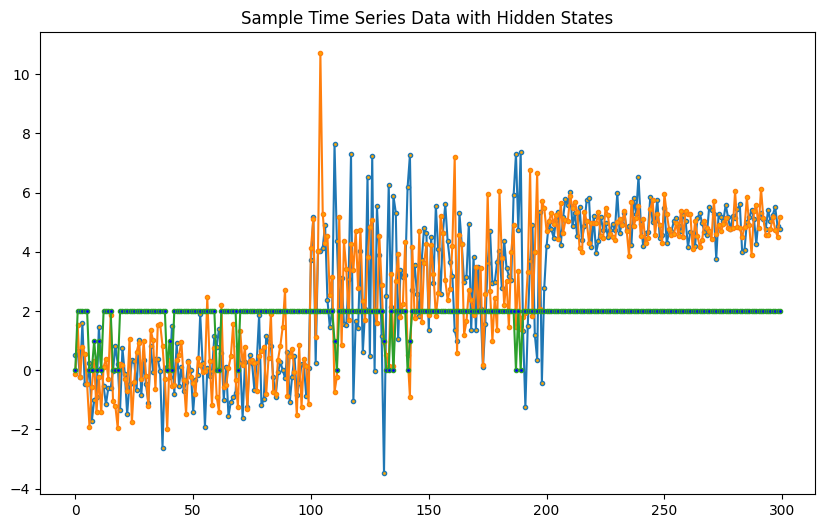

In [ ]:
# Plot hidden state on top of the sample data
plt.figure(figsize=(10, 6))
plt.plot(X[:, 0], ".-", label="observations", ms=6, mfc="orange")
plt.plot(X[:, 1], ".-", label="observations", ms=6, mfc="orange")
plt.plot(path, ".-", label="hidden states", ms=6, mfc="blue")
plt.title("Sample Time Series Data with Hidden States")
plt.show()


## Model selection with Bayesian Information Criterion (BIC)

TODO by students

The Bayesian Information Criterion (BIC) is a criterion for model selection among a finite set of models; it is based on the likelihood function and takes into consideration the number of parameters in the model. It is particularly useful in scenarios like selecting the best Hidden Markov Model (HMM) from a set of HMMs that differ in the number of states or in the structure of the transition matrix.

The formula for BIC is given by:

\[ \text{BIC} = -2 \cdot \ln(\hat{L}) + k \cdot \ln(n) \]

where:
- \(\hat{L}\) is the maximized value of the likelihood function of the model. For HMMs, this is typically obtained using algorithms like the Baum-Welch algorithm, which finds the set of model parameters that maximizes the likelihood of the observed sequence of emissions.
- \(k\) is the number of free parameters to be estimated. In the context of HMMs, this includes the parameters of the emission probability distributions, the initial state distribution, and the state transition probabilities.
- \(n\) is the number of data points, which, for HMMs, would be the length of the observed sequence of emissions. If the model is fitted on multiple sequences, n would be the sum of the lengths of all sequences.

The BIC penalizes complex models, which is reflected by the term involving the number of parameters \(k\). The idea is to balance model complexity with goodness of fit. Lower values of BIC indicate a better model, taking into consideration both the likelihood and the number of parameters. When selecting among multiple HMMs, the one with the lowest BIC is generally preferred as it suggests the model is more likely to be the true generator of the observed data, without being unnecessarily complex.





